# Código Clasificación buques mercantes utilizando CNN.
### Cristóbal Balmelli Scheel

## Descripción de la máquina en la que se está corriendo

In [1]:
# Conocer version de paquetes y Hardware en uso

import sys
import keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
import platform

print(f"Plataforma (Software-Hardware): {platform.platform()}")
print(f"Versión de Python {sys.version}")
print(f"Versión de TensorFlow: {tf.__version__}")
print(f"versión de Pandas {pd.__version__}")
print(f"versión de Numpy {np.__version__}")
print(f"versión de Keras {keras.__version__}")
print(f"Versión de Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU está", "Disponible" if gpu else "No Disponible")

Plataforma (Software-Hardware): Windows-10-10.0.19045-SP0
Versión de Python 3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]
Versión de TensorFlow: 2.13.0
versión de Pandas 2.0.1
versión de Numpy 1.23.5
versión de Keras 2.13.1
Versión de Scikit-Learn 1.2.2
GPU está No Disponible


## Cargamos las librerias necesarias

In [2]:
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
from keras.utils import to_categorical
from keras.models import Sequential,Model
#from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D
#from tensorflow.keras.activations import relu
#from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2


## Cargamos las imagenes

In [3]:
#Variables que almacenan los tamaños de las imágenes a procesar
altura, longitud = 100, 100

#Se define función para cargar y redimensionar las imágenes, retorna una lista de las imágenes redimensionadas
def cargar_y_redimensionar_imagenes(ruta):
    imagenes_redimensionadas = []
    for archivo in os.listdir(ruta):
        archivo_ruta = os.path.join(ruta, archivo)
        # Verificamos si el archivo es una imagen válida antes de abrirlo con OpenCV
        imagen = cv2.imread(archivo_ruta)
        if imagen is not None and len(imagen.shape) == 3 and imagen.shape[2] == 3:
            imagen = cv2.resize(imagen, (altura, longitud))
            imagenes_redimensionadas.append(imagen)
    return imagenes_redimensionadas

# Rutas de los directorios de las imágenes
ruta_mercantes = './datos/mercantes'
ruta_otros = './datos/otros'

# Cargar y redimensionar imágenes de mercantes y no mercantes, llamados "otros" 
imagenes_mercantes = cargar_y_redimensionar_imagenes(ruta_mercantes)
imagenes_otros = cargar_y_redimensionar_imagenes(ruta_otros)

# Obtener la cantidad de imágenes en cada directorio
dircount = [len(imagenes_mercantes), len(imagenes_otros)]

#Imprimir en pantalla las cantidades de imágenes en cada directorio
print('Imagenes en cada directorio:', dircount)
print('Suma Total de imagenes en subdirectorios:', sum(dircount))

Imagenes en cada directorio: [56, 35]
Suma Total de imagenes en subdirectorios: 91


## Crear etiquetas y clases

Creamos los labels con valor 1 para mercante y 0 para otros

In [4]:
# Crear una lista de etiquetas
etiquetas_mercantes = [0] * len(imagenes_mercantes)
etiquetas_otros = [1] * len(imagenes_otros)

# Combinar las imágenes y etiquetas en un solo conjunto de datos
imagenes = imagenes_mercantes + imagenes_otros
etiquetas = etiquetas_mercantes + etiquetas_otros

## Muestra de imágenes

Text(0.5, 1.0, 'Imagen ISAR etiquetada como mercante')

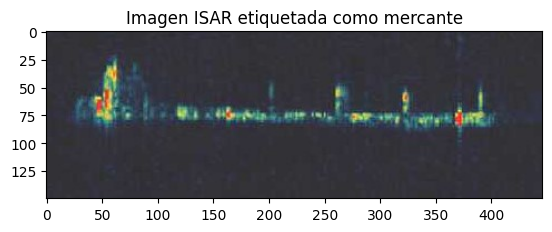

In [5]:
# Muestra de Etiqueta Mercante:
import matplotlib.pyplot as plt
plt.imshow(plt.imread('datos/mercantes/10.jpg'))
plt.title('Imagen ISAR etiquetada como mercante')

Text(0.5, 1.0, 'Imagen ISAR etiquetada como no mercante')

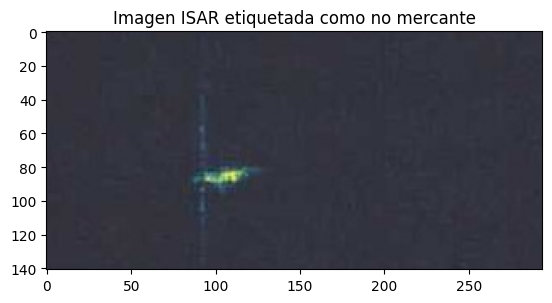

In [6]:
# Muestra de Etiqueta Otros:
import matplotlib.pyplot as plt
plt.imshow(plt.imread('datos/otros/11.jpg'))
plt.title('Imagen ISAR etiquetada como no mercante')

## Creamos sets de Entrenamiento y Test

In [7]:
# Convertir a arreglos NumPy
X = np.array(imagenes, dtype=np.uint8)
y = np.array(etiquetas)

# Dividir los datos en conjuntos de entrenamiento y validación (80% para entrenamiento, 20% para validación)
train_X, valid_X, train_label, valid_label = train_test_split(X, y, test_size=0.2, random_state=218) #num de cadete

# Se normalizan los datos valores entre 0 y 1
train_X = train_X / 255.
valid_X = valid_X / 255.

# Calcular e imprimir el número de clases usadas
classes = np.unique(train_label)
nClasses = len(classes)
print('Total number of outputs:', nClasses)
print('Output classes:', classes)

# Convierte los datos de vectores a arreglos matriciales binarios
train_label_one_hot = to_categorical(train_label, num_classes=nClasses)
valid_label_one_hot = to_categorical(valid_label, num_classes=nClasses)

Total number of outputs: 2
Output classes: [0 1]


## Data augmentation

In [10]:
# Configurar las transformaciones de data augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=20,         # Rango de rotación aleatoria (en grados)
    width_shift_range=0.2,     # Rango de traslación horizontal aleatoria (como fracción del ancho total)
    height_shift_range=0.2,    # Rango de traslación vertical aleatoria (como fracción del alto total)
    shear_range=0.2,           # Rango de cizallamiento (shear) aleatorio
    zoom_range=0.2,            # Rango de zoom aleatorio
    horizontal_flip=True,      # Volteo horizontal aleatorio
    fill_mode='nearest'        # Modo de rellenado para las transformaciones
)

## Creamos la red neuronal convolucional

In [8]:
# Se define el learning rate de la red
INIT_LR = 0.0001

filtrosConv1=32 #despoues de la 1ra conv, la imagen va a tener prof de 32
filtrosConv2=64 #despjes de la 2da, tendra 64
filtrosConv3=128
tamano_filtro1=(5,5)
tamano_filtro2=(3,3)
tamano_pool=(2,2)

modelo = Sequential(name='modelo_edu')
modelo.add(Convolution2D(filtrosConv1, tamano_filtro1, padding='same', input_shape=(altura,longitud,3),activation='relu'))
modelo.add(MaxPooling2D(pool_size=tamano_pool))

#segunda capa de convolucion (), seguida de una capa de max pooling
modelo.add(Convolution2D(filtrosConv2, tamano_filtro2, padding='same', activation='relu'))
modelo.add(MaxPooling2D(pool_size=tamano_pool))

#capa que aplana la imagen (1D)
modelo.add(Flatten())

#capa normal, de 256 neuronas
modelo.add(Dense(256,activation='relu'))

#capa que apagara el 50% de las neuronas en cada paso, para evitar el overfitting
modelo.add(Dropout(0.5))

#ultima capa, que son 2 neuronas (una por clase) donde dara % prob da cada clase
modelo.add(Dense(nClasses,activation='softmax'))

#con Graphviz se puede hacer un diagrama de flujo para ver la logica del sistema
modelo.summary()

modelo.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=INIT_LR),metrics=['accuracy'])

Model: "modelo_edu"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 25, 25, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 40000)             0         
                                                                 
 dense (Dense)               (None, 256)               1

**Cristóbal, Aprender esta tabla que explica como se calcula todo en el modelo anterior:**

| Layer (type) | Param Definition | Input Shape | Output Shape | Param Calculation (Formula and Values) | Param # |
| --- | --- | --- | --- | --- | --- |
| Conv2D | Kernel: (3,3) | (100, 100, 3) | (100, 100, 32) | (altura x ancho x canales_entrada + 1 bias) x filtros = (3x3x3+1) x 32 | 896 |
| MaxPooling2D | Tamaño del Pool: (2,2) | (100, 100, 32) | (50, 50, 32) | 0 (No hay parámetros en las capas de pooling) | 0 |
| Conv2D | Kernel: (2,2) | (50, 50, 32) | (50, 50, 64) | (altura x ancho x canales_entrada + 1 bias) x filtros = (2x2x32+1) x 64 | 8,256 |
| MaxPooling2D | Tamaño del Pool: (2,2) | (50, 50, 64) | (25, 25, 64) | 0 (No hay parámetros en las capas de pooling) | 0 |
| Flatten | N/A | (25, 25, 64) | (40,000) | 0 (No hay parámetros en las capas flatten) | 0 |
| Dense | Unidades: 256 | (40,000) | (256) | (entrada x salida + 1 bias por unidad salida) = (40,000 x 256) + 256 | 10,240,256 |
| Dropout | Rate: 0.5 | (256) | (256) | 0 (No hay parámetros en las capas de dropout) | 0 |
| Dense | Unidades: 2 | (256) | (2) | (entrada x salida + 1 bias por unidad salida) = (256 x 2) + 2 | 514 |

## Entrenamos la red


In [11]:
# Define cantidad de épocas
epochs = 150

# Define tamaño de batch utilizados
batch_size = 32

# Crear el generador de datos para el conjunto de entrenamiento con data augmentation
train_data_generator = data_augmentation.flow(train_X, train_label_one_hot, batch_size=batch_size)

# Modifica el train_x para incluir las imagenes del train_data_generator
history=modelo.fit(train_data_generator, steps_per_epoch=len(train_X) // batch_size, epochs=epochs, verbose=1, validation_data=(valid_X, valid_label_one_hot))

# Se guarda la red, para reutilizarla en el futuro, sin tener que volver a entrenar
dir='./modelo/'

if not os.path.exists(dir):
    os.mkdir(dir)
modelo.save('./modelo/modelo.h5')
modelo.save_weights('./modelo/pesos.h5')

Epoch 1/150
2/2 [==============================] - 3s 760ms/step - loss: 0.6839 - accuracy: 0.6000 - val_loss: 0.6536 - val_accuracy: 0.6316
Epoch 2/150
2/2 [==============================] - 1s 444ms/step - loss: 0.6554 - accuracy: 0.6406 - val_loss: 0.6512 - val_accuracy: 0.6316
Epoch 3/150
2/2 [==============================] - 1s 262ms/step - loss: 0.6493 - accuracy: 0.6000 - val_loss: 0.6468 - val_accuracy: 0.6316
Epoch 4/150
2/2 [==============================] - 1s 432ms/step - loss: 0.7321 - accuracy: 0.5156 - val_loss: 0.6466 - val_accuracy: 0.6316
Epoch 5/150
2/2 [==============================] - 1s 462ms/step - loss: 0.6773 - accuracy: 0.6500 - val_loss: 0.6472 - val_accuracy: 0.6316
Epoch 6/150
2/2 [==============================] - 1s 256ms/step - loss: 0.6541 - accuracy: 0.6500 - val_loss: 0.6504 - val_accuracy: 0.6316
Epoch 7/150
2/2 [==============================] - 1s 555ms/step - loss: 0.7778 - accuracy: 0.5750 - val_loss: 0.6535 - val_accuracy: 0.6316
Epoch 8/150
2

C:\Users\cbalm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Obtenemos las métricas de entrenamiento y validación, luego graficamos

### Matriz de confusion



1/1 [==============================] - 0s 85ms/step


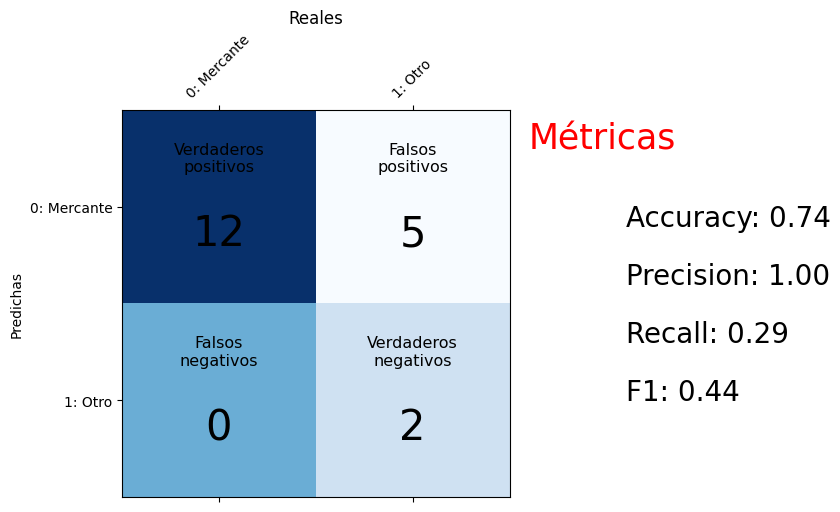

In [14]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

# Función que retorna las métricas a utilizar
def metricas(clases_reales, clases_predichas):
    matriz_conf=confusion_matrix(clases_reales, clases_predichas)
    accuracy=accuracy_score(clases_reales,clases_predichas)
    precision=precision_score(clases_reales,clases_predichas)
    recall=recall_score(clases_reales,clases_predichas)
    f1=f1_score(clases_reales,clases_predichas)
    return matriz_conf, accuracy, recall, precision, f1

# Función que grafica la matriz de confusión
def visualizar_metricas(clases_reales,clases_predichas, titulo):
    #Calculamos metricas con la funcion previa
    matriz, accuracy, recall, precision, f1=metricas(clases_reales,clases_predichas)

    #Graficamos
    plt.figure(figsize=(5,5))
    matriz=pd.DataFrame(matriz,columns=['0: Mercante', '1: Otro'])
    plt.matshow(matriz, cmap="Blues", vmin=0, vmax=10, fignum=1)
    plt.title("Reales")
    plt.ylabel("Predichas")
    plt.xticks(range(len(matriz.columns)), matriz.columns, rotation=45)
    plt.yticks(range(len(matriz.columns)), matriz.columns)
    etiquetas = (("Verdaderos\npositivos", "Falsos\nnegativos"),
                 ("Falsos\npositivos", "Verdaderos\nnegativos"))
    for i in range(len(matriz.columns)):
        for j in range(len(matriz.columns)):
            plt.text(i, j + 0.14, str(matriz.iloc[i, j]),
                     fontsize=30, ha="center", va="center")
            plt.text(i, j - 0.25, etiquetas[i][j],
                     fontsize=11.5, ha="center", va="center")           
    plt.text(1.60, -0.30, titulo, fontsize=25, c="red")
    plt.text(2.1, 0.10, "Accuracy: %0.2f" % accuracy, fontsize=20)
    plt.text(2.1, 0.40, "Precision: %0.2f" % precision, fontsize=20)
    plt.text(2.1, 0.70, "Recall: %0.2f" % recall, fontsize=20)
    plt.text(2.1, 1.00, "F1: %0.2f" % f1, fontsize=20)    
    plt.show()
    print("\n")

print("\n")

predicciones = modelo.predict(valid_X)
clases_predichas = np.argmax(predicciones, axis=1)
matriz_confusion = confusion_matrix(valid_label, clases_predichas)

visualizar_metricas(valid_label,clases_predichas,'Métricas')


### Métricas del entranamiento

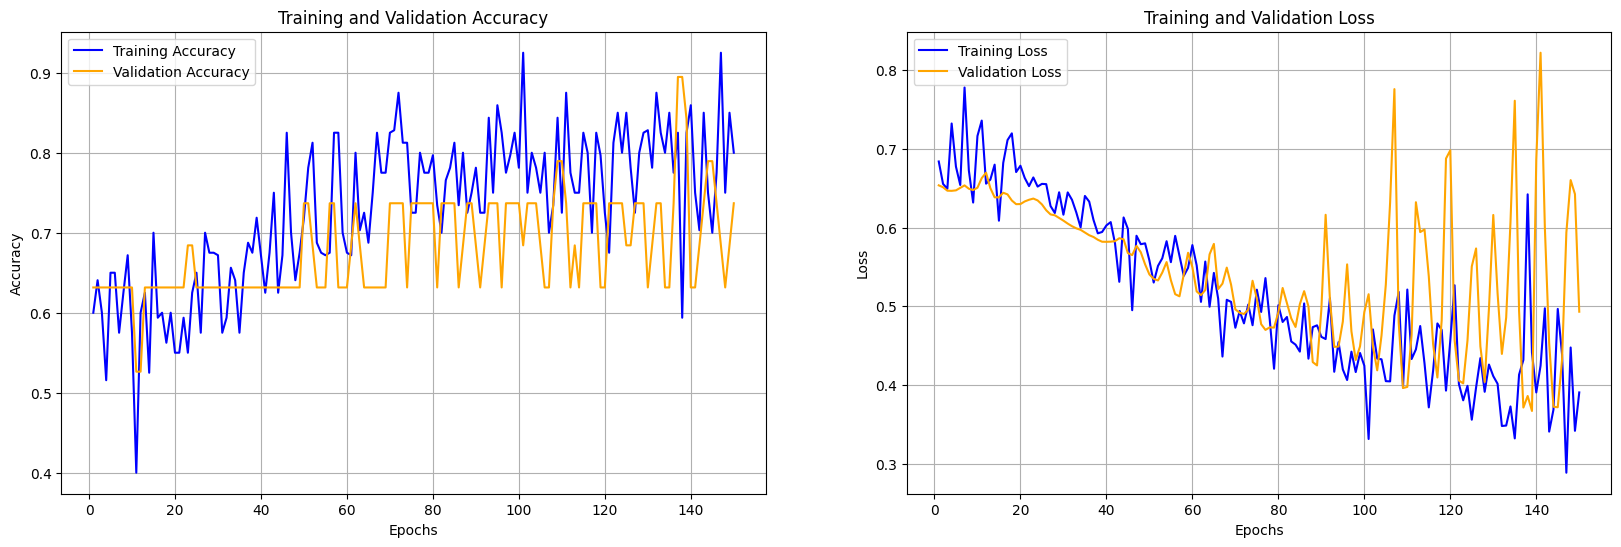

In [24]:
# Obtener las métricas de entrenamiento y validación
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(20,6))

# Gráfica de precisión (accuracy)
plt.subplot(1,2,1)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
# Gráfica de pérdida (loss)
plt.plot(epochs_range, train_loss, label='Training Loss', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Probamos la red

1/1 [==============================] - 0s 48ms/step


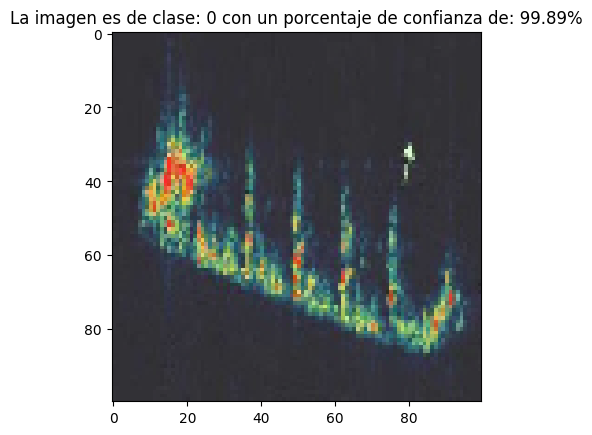


Arreglo de pixeles de la imagen:
 [[ 49  50  50  50  51  53  51  50  50  50  50  50  50  50  50  50  50  50  50  50  52  48  50  53  49  51  52  52  50  49]
 [ 50  50  50  50  51  54  52  50  50  50  50  50  49  51  50  50  50  52  52  52  51  50  50  52  49  50  52  52  50  50]
 [ 50  50  48  49  57  51  51  50  50  50  50  51  51  51  50  50  50  52  51  51  50  51  50  51  51  50  50  51  50  50]
 [ 49  51  50  47  57  60  51  51  49  50  50  51  50  50  50  50  49  50  49  52  50  50  50  48  49  50  52  52  50  50]
 [ 50  51  50  48  55  64  50  52  49  50  51  50  51  50  50  50  50  50  50  51  49  50  50  49  50  50  50  52  50  50]
 [ 48  50  50  51  56  86  54  50  50  50  50  50  50  51  50  50  50  50  50  52  48  49  50  48  50  50  53  53  50  50]
 [ 51  50  50  51  63  89  56  53  50  50  50  50  50  52  50  50  50  50  50  53  51  50  50  48  51  51  50  51  49  50]
 [ 50  49  51  53  72 127  65  54  50  49  50  51  50  52  49  50  50  50  52  53  50  50  50  47  50  5

In [33]:
from skimage import color

#directorio_imagen_prueba='./prueba/1.jpg'
directorio_imagen_prueba='./datos/mercantes/1.jpg'
# Carga la imagen de prueba
imagen_prueba = cv2.imread(directorio_imagen_prueba)
imagen_prueba = cv2.resize(imagen_prueba, (100, 100))

# OpenCV lee las imágenes en formato BGR, pero los modelos de Keras están entrenados con imágenes en formato RGB, por lo que es necesario convertir la imagen de BGR a RGB
imagen_prueba = cv2.cvtColor(imagen_prueba, cv2.COLOR_BGR2RGB)

# Convertir a float32 y normalizar
imagen_prueba = imagen_prueba.astype('float32') / 255.0

# Ajusta las dimensiones de la imagen para que sea compatible con la entrada del modelo
imagen_prueba = np.expand_dims(imagen_prueba, axis=0)

# Obtén las predicciones utilizando el modelo entrenado
predicciones = modelo.predict(imagen_prueba)

# Las predicciones son un arreglo de probabilidades, conviértelas a una clase
clase_predicha = np.argmax(predicciones[0])

# Obten la clase correspondiente al índice
clase = classes[clase_predicha]

# Obten el porcentaje de confianza para la clase predicha
porcentaje_confianza = predicciones[0][clase_predicha] * 100

# Carga la imagen de nuevo para mostrarla (esta vez en formato RGB para matplotlib)
imagen_prueba = cv2.cvtColor(cv2.imread(directorio_imagen_prueba), cv2.COLOR_BGR2RGB)
imagen_prueba = cv2.resize(imagen_prueba, (100, 100))
imagen_array = np.array(imagen_prueba) # Arreglo de pixeles de la imagen

# Imprime en pantalla la imagen clasificada, con su porcentaje de confianza
plt.imshow(imagen_prueba)
plt.title("La imagen es de clase: {} con un porcentaje de confianza de: {:.2f}%".format(clase, porcentaje_confianza))
plt.show()

# Ajusta la imagen para luego convertirla en una matriz de pixeles de 30x30
imagen_prueba1=cv2.resize(imagen_prueba, (30, 30))
imagen_array1=np.array(imagen_prueba1)

# Aproximar los valores de píxeles a la unidad
imagen_pixeles = np.round(color.rgb2gray(imagen_array1) * 255).astype(int)

# Muestra en pantalla la imagen como matriz de valores de pixeles, entre 0 y 255
np.set_printoptions(linewidth=np.inf)
print(f'\nArreglo de pixeles de la imagen:\n {imagen_pixeles}')